전처리 완료: X shape=(1560, 7, 55), y shape=(1560,)
Train shape: X_train=(1248, 7, 55), y_train=(1248,)
Test shape: X_test=(312, 7, 55), y_test=(312,)
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.7074 - loss: 0.6164 - val_accuracy: 0.8720 - val_loss: 0.3517 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8862 - loss: 0.2862 - val_accuracy: 0.9360 - val_loss: 0.1660 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9758 - loss: 0.0962 - val_accuracy: 0.9680 - val_loss: 0.0818 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9808 - loss: 0.0511 - val_accuracy: 0.9840 - val_loss: 0.0362 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9994 - loss: 0.0130 - val_accuracy: 0.9880 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9978 - loss: 0.0081 - val_accuracy

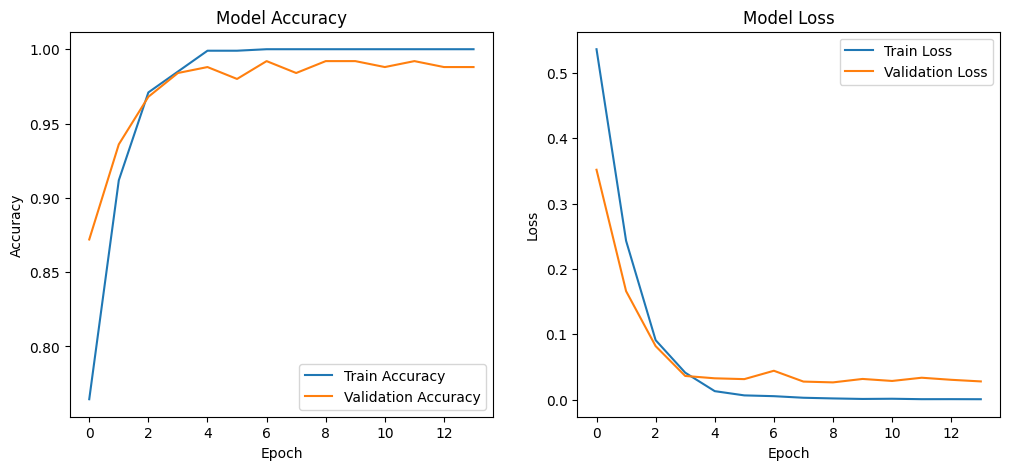

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9896 - loss: 0.0258     
Test Accuracy: 99.04%
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Classification Report:
              precision    recall  f1-score   support

    Non-Fall       1.00      0.96      0.98        78
        Fall       0.99      1.00      0.99       234

    accuracy                           0.99       312
   macro avg       0.99      0.98      0.99       312
weighted avg       0.99      0.99      0.99       312



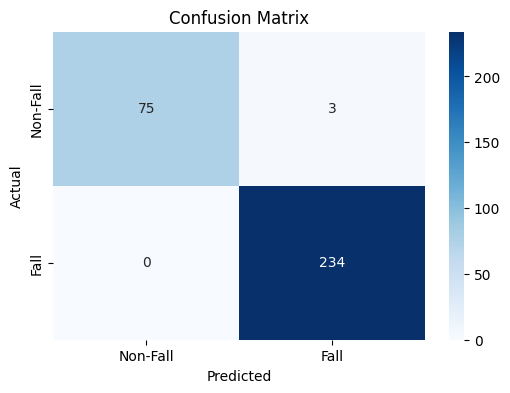

Accuracy: 0.9904
Precision: 0.9873
Recall: 1.0000
F1 Score: 0.9936


In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Concatenate
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

# 데이터 전처리 함수
def preprocess_without_subject(file_path, timesteps=7):
    # 데이터 로드
    df = pd.read_csv(file_path)

    # 시간 순서로 정렬 (status, interval 기준)
    df = df.sort_values(by=['status', 'interval'])

    # 필요한 열 선택 (subject 제외)
    features = [col for col in df.columns if col not in ['subject', 'status', 'interval', 'label']]
    label_col = 'label'

    X, y = [], []

    # status별 데이터 처리
    grouped = df.groupby('status')

    for _, group in grouped:
        feature_data = group[features].values  # feature 데이터
        label_data = group[label_col].values  # label 데이터

        # StandardScaler로 정규화
        scaler = StandardScaler()
        feature_data = scaler.fit_transform(feature_data)

        # 데이터가 timesteps보다 짧으면 제외
        if len(feature_data) < timesteps:
            continue

        # timesteps 크기로 데이터 묶기
        for i in range(len(feature_data) - timesteps + 1):
            X.append(feature_data[i:i + timesteps])  # 연속된 timesteps 크기 데이터
            y.append(label_data[i + timesteps - 1])  # 해당 시점의 마지막 라벨 사용

    return np.array(X), np.array(y)

# 데이터 전처리 실행
file_path = r"D:\deep_learning\preprocessed_cleaned_data.csv"
timesteps = 7
X, y = preprocess_without_subject(file_path, timesteps=timesteps)

print(f"전처리 완료: X shape={X.shape}, y shape={y.shape}")

# 학습 및 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

print(f"Train shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Test shape: X_test={X_test.shape}, y_test={y_test.shape}")

# Multi-Interval LSTM-CNN 모델 정의
def create_multi_interval_lstm_cnn():
    inputs = Input(shape=(timesteps, X.shape[2]))  # timesteps=5, features=54
    lstm_out = LSTM(150, return_sequences=False)(inputs)
    conv_out = Conv1D(96, kernel_size=3, activation='relu', padding='same')(inputs)
    pool_out = MaxPooling1D(pool_size=2)(conv_out)
    combined = Concatenate()([lstm_out, Flatten()(pool_out)])
    dense1 = Dense(32, activation='relu')(combined)
    dropout = Dropout(0.3)(dense1)
    outputs = Dense(2, activation='softmax')(dropout)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성
model = create_multi_interval_lstm_cnn()

# 학습 설정
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

# 학습 과정 시각화
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    plt.show()

plot_training_history(history)

# 모델 평가
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 성능 평가
def evaluate_model_performance(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['Non-Fall', 'Fall']))
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
    print(f'Precision: {precision_score(y_true, y_pred):.4f}')
    print(f'Recall: {recall_score(y_true, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_true, y_pred):.4f}')

# 예측 수행 및 평가
y_pred = np.argmax(model.predict(X_test), axis=1)
evaluate_model_performance(y_test, y_pred)



timestep 별 성능 비교


=== Evaluating for timesteps=3 ===
Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7004 - loss: 0.5796 - val_accuracy: 0.8626 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8574 - loss: 0.3754 - val_accuracy: 0.8779 - val_loss: 0.3059 - learning_rate: 0.0010
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8897 - loss: 0.2773 - val_accuracy: 0.9046 - val_loss: 0.2342 - learning_rate: 0.0010
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9358 - loss: 0.1934 - val_accuracy: 0.9198 - val_loss: 0.2008 - learning_rate: 0.0010
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9499 - loss: 0.1341 - val_accuracy: 0.9389 - val_loss: 0.1501 - learning_rate: 0.0010
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9687 - loss: 0.1141 - val_accuracy: 0.9466 - val_loss: 0.1375 - learning_rate: 0.0010
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accurac

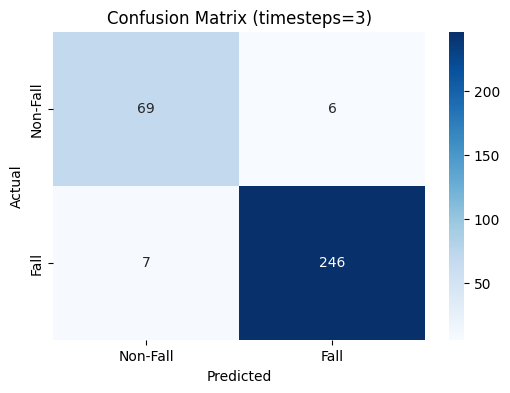


=== Evaluating for timesteps=5 ===
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6115 - loss: 0.7005 - val_accuracy: 0.8320 - val_loss: 0.4051 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8932 - loss: 0.3400 - val_accuracy: 0.9258 - val_loss: 0.2572 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9347 - loss: 0.1991 - val_accuracy: 0.9375 - val_loss: 0.1651 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9673 - loss: 0.1167 - val_accuracy: 0.9727 - val_loss: 0.1040 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9896 - loss: 0.0594 - val_accuracy: 0.9727 - val_loss: 0.0715 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9907 - loss: 0.0402 - val_accuracy: 0.9844 - val_loss: 0.0598 - learning_rate: 0.0010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accur

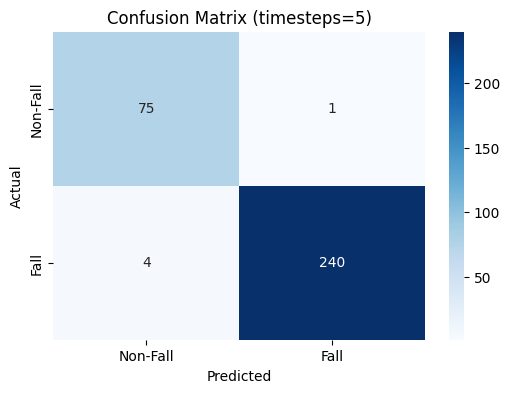


=== Evaluating for timesteps=7 ===
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.6850 - loss: 0.6731 - val_accuracy: 0.9080 - val_loss: 0.3651 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9006 - loss: 0.3047 - val_accuracy: 0.9360 - val_loss: 0.1750 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9669 - loss: 0.1264 - val_accuracy: 0.9600 - val_loss: 0.0928 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9786 - loss: 0.0680 - val_accuracy: 0.9840 - val_loss: 0.0546 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9847 - loss: 0.0386 - val_accuracy: 0.9880 - val_loss: 0.0332 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9991 - loss: 0.0154 - val_accuracy: 0.9840 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accur

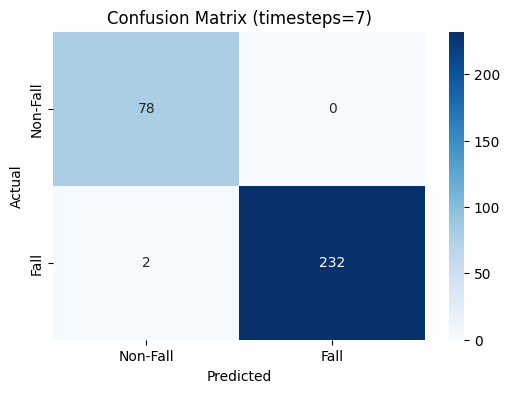


=== Evaluating for timesteps=10 ===
Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5906 - loss: 0.8246 - val_accuracy: 0.8465 - val_loss: 0.4106 - learning_rate: 0.0010
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8745 - loss: 0.3502 - val_accuracy: 0.9502 - val_loss: 0.1799 - learning_rate: 0.0010
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9518 - loss: 0.1503 - val_accuracy: 0.9917 - val_loss: 0.0470 - learning_rate: 0.0010
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9865 - loss: 0.0568 - val_accuracy: 0.9917 - val_loss: 0.0198 - learning_rate: 0.0010
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9974 - loss: 0.0135 - val_accuracy: 0.9959 - val_loss: 0.0068 - learning_rate: 0.0010
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9954 - loss: 0.0097 - val_accuracy: 1.0000 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accu

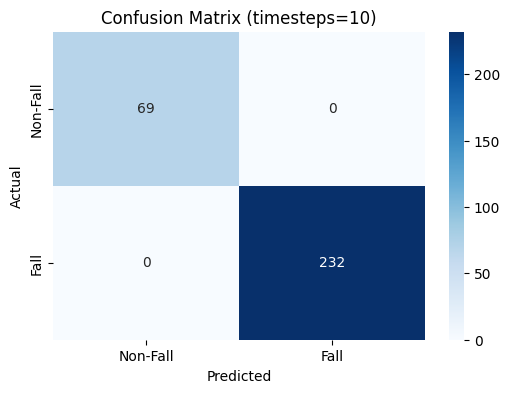


=== Performance Comparison ===
   timesteps  accuracy  precision    recall  f1_score
0          3  0.960366   0.960574  0.960366  0.960458
1          5  0.984375   0.984811  0.984375  0.984478
2          7  0.993590   0.993750  0.993590  0.993617
3         10  1.000000   1.000000  1.000000  1.000000


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리 함수
def preprocess_without_subject(file_path, timesteps):
    df = pd.read_csv(file_path)
    df = df.sort_values(by=['status', 'interval'])  # status와 interval 기준으로 정렬

    features = [col for col in df.columns if col not in ['subject', 'status', 'interval', 'label']]
    label_col = 'label'

    X, y = [], []

    grouped = df.groupby('status')  # status별로 데이터 그룹화

    for _, group in grouped:
        feature_data = group[features].values
        label_data = group[label_col].values

        scaler = StandardScaler()
        feature_data = scaler.fit_transform(feature_data)

        if len(feature_data) < timesteps:
            continue

        for i in range(len(feature_data) - timesteps + 1):
            X.append(feature_data[i:i + timesteps])
            y.append(label_data[i + timesteps - 1])

    return np.array(X), np.array(y)

# 모델 정의 함수
def create_multi_interval_lstm_cnn(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))  # timesteps 크기와 입력 차원에 맞게 정의
    lstm_out = LSTM(150, return_sequences=False)(inputs)
    conv_out = Conv1D(96, kernel_size=3, activation='relu', padding='same')(inputs)
    pool_out = MaxPooling1D(pool_size=2)(conv_out)
    combined = Concatenate()([lstm_out, Flatten()(pool_out)])
    dense1 = Dense(32, activation='relu')(combined)
    dropout = Dropout(0.3)(dense1)
    outputs = Dense(2, activation='softmax')(dropout)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# 성능 평가 함수
def evaluate_performance(timesteps, file_path):
    print(f"\n=== Evaluating for timesteps={timesteps} ===")
    X, y = preprocess_without_subject(file_path, timesteps=timesteps)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

    model = create_multi_interval_lstm_cnn(timesteps, X.shape[2])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    y_pred = np.argmax(model.predict(X_test), axis=1)

    # 성능 지표 계산
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Classification Report
    report = classification_report(y_test, y_pred, target_names=['Non-Fall', 'Fall'])
    print("Classification Report:")
    print(report)

    # Confusion Matrix 시각화
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fall', 'Fall'], yticklabels=['Non-Fall', 'Fall'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix (timesteps={timesteps})')
    plt.show()

    return {"timesteps": timesteps, "accuracy": acc, "precision": precision, "recall": recall, "f1_score": f1}

# 평가 실행
file_path = r"D:\deep_learning\preprocessed_cleaned_data.csv"
results = []

for ts in [3, 5, 7, 10]:
    result = evaluate_performance(ts, file_path)
    results.append(result)

# 성능 비교 출력
results_df = pd.DataFrame(results)
print("\n=== Performance Comparison ===")
print(results_df)
